In [1]:
from tensorflow import Tensor
import keras,os
from keras.models import Sequential
import numpy as np
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,AveragePooling2D,ReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import HeNormal
from keras import regularizers
from sklearn.metrics import recall_score,precision_score
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.datasets import cifar100
%load_ext tensorboard
from keras.layers import Input, Add
from keras.models import Model
from keras.optimizers import Adam,SGD
from keras.losses import categorical_crossentropy

In [2]:
(x_train,y_train),(x_test,y_test) = cifar100.load_data()

169009152/169001437 [==============================] - 4s 0us/step


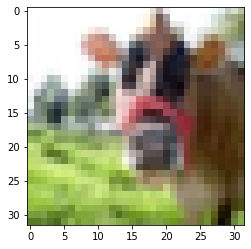

In [3]:
plt.imshow(x_train[0])

In [4]:
def normalize(X_train,X_test):
    #this function normalize inputs for zero mean and unit variance
    # it is used when training a model.
    # Input: training set and test set
    # Output: normalized training set and test set according to the trianing set statistics.
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    print(mean)
    print(std)
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = normalize(x_train, x_test)

121.93584
68.38902


In [6]:
from keras.utils import to_categorical
y_train = keras.utils.to_categorical(y_train, 100)
y_test = keras.utils.to_categorical(y_test, 100)

In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
def create_res_net():
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    kernel_size = 3
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3, strides=1, filters=num_filters, padding="same")(t)
    t = BatchNormalization()(t)
    t = LeakyReLU(0.1)(t)

    t = MaxPool2D(pool_size=(2,2),strides=2)(t)

    y = Conv2D(kernel_size=kernel_size, strides= 1, filters=num_filters,padding="same")(t)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.1)(y)
    y = Conv2D(kernel_size=kernel_size, strides=1,filters=num_filters,padding="same")(y) 
    #y = BatchNormalization()(y)

    t = Conv2D(kernel_size=1, strides=1,filters=num_filters,padding="same")(t)
    #t = BatchNormalization()(t)
    y = Add()([t, y])
    a = LeakyReLU(0.1)(y)

    a = MaxPool2D(pool_size=(2,2),strides=2)(a)

    y = Conv2D(kernel_size=kernel_size, strides= 1, filters=num_filters,padding="same")(a)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.1)(y)
    y = Conv2D(kernel_size=kernel_size, strides=1,filters=num_filters,padding="same")(y) 

    a = Conv2D(kernel_size=1, strides=1,filters=num_filters,padding="same")(a)
    y = Add()([a, y])
    b = LeakyReLU(0.1)(y)

    y = Conv2D(kernel_size=kernel_size, strides=1, filters=128,padding="same")(b)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.1)(y)
    y = Conv2D(kernel_size=kernel_size, strides=1,filters=128,padding="same")(y)
    #y = LeakyReLU(0.1)(y)
    b = Conv2D(kernel_size=1, strides=1,filters=128,padding="same")(b)
    y = Add()([b, y])
    c = LeakyReLU(0.1)(y)

    y = Conv2D(kernel_size=kernel_size, strides=1, filters=128,padding="same")(c)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.1)(y)
    y = Conv2D(kernel_size=kernel_size, strides=1,filters=128,padding="same")(y)
    #y = LeakyReLU(0.1)(y)
    c = Conv2D(kernel_size=1, strides=1,filters=128,padding="same")(c)
    y = Add()([c, y])
    d = LeakyReLU(0.1)(y)
 
    y = Conv2D(kernel_size=kernel_size, strides= 1, filters=256,padding="same")(d)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.1)(y)
    y = Conv2D(kernel_size=kernel_size, strides=1,filters=256,padding="same")(y)
    #y = LeakyReLU(0.1)(y)
    d = Conv2D(kernel_size=1, strides=1,filters=256,padding="same")(d)
    y = Add()([d, y])
    f = LeakyReLU(0.1)(y)
 
    y = Conv2D(kernel_size=kernel_size, strides= 1, filters=512,padding="same")(f)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.1)(y)
    y = Conv2D(kernel_size=kernel_size, strides=1,filters=512,padding="same")(y)
    #y = LeakyReLU(0.1)(y)
    f = Conv2D(kernel_size=1, strides=1,filters=512,padding="same")(f)
    y = Add()([f, y])
    h = LeakyReLU(0.1)(y)


    h = AveragePooling2D(4)(h)
    h = Flatten()(h)
    d1 = Dense(1024,activation = LeakyReLU(0.1))(h)
    outputs = Dense(100, activation='softmax')(d1)
    
    model = Model(inputs, outputs)
    learnrate = 1e-3
    #opt = Adam(lr=learnrate,clipnorm = 1.0)
    model.compile(
        optimizer= 'sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping

In [10]:
model = create_res_net()
model.summary()

callback = ModelCheckpoint('resnet_sgd_BN.h5',monitor='val_accuracy',save_best_only=True,save_weights_only=True,mode='auto')
early =  EarlyStopping(monitor='val_accuracy',min_delta = 0, patience = 20,verbose =1,mode = 'auto')
tensor_board = TensorBoard(log_dir='tb_logs/tensorboard',histogram_freq=1)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d[0][0]                     
_______________________________________________________________________________________

In [14]:
#Loading the saved weights

filename = '../weights/resnet_sgd_BN_without_L2.h5'
model.load_weights(filename)
test_acc = model.evaluate(x_test,y_test)
test_acc
# Test the model
y_true = y_test.argmax(-1)
y_pred = model.predict(x_test).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
confusion_matrix(y_true, y_pred)
# calculate prec, recall, accuracy
print("Prec: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

313/313 [==============================] - 2s 7ms/step - loss: 3.1584 - accuracy: 0.5168
Prec: 0.5181377266101974
Recall: 0.5168
Accuracy: 0.5168


In [ ]:
output = model.fit(x=x_train,y=y_train,batch_size = 128, epochs = 100,verbose =1,validation_data = (x_test,y_test),callbacks = [callback,early,tensor_board])

Epoch 1/100
  1/391 [..............................] - ETA: 0s - loss: 4.7640 - accuracy: 0.0078WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
391/391 [==============================] - 22s 58ms/step - loss: 3.8834 - accuracy: 0.1163 - val_loss: 3.8930 - val_accuracy: 0.1044
Epoch 2/100
391/391 [==============================] - 22s 55ms/step - loss: 3.2366 - accuracy: 0.2152 - val_loss: 3.4031 - val_accuracy: 0.1891
Epoch 3/100
391/391 [==============================] - 22s 56ms/step - loss: 2.9015 - accuracy: 0.2764 - val_loss: 2.9445 - val_accuracy: 0.2665
Epoch 4/100
391/391 [==============================] - 22s 56ms/step - loss: 2.6411 - accuracy: 0.3243 - val_loss: 2.7556 - val_accuracy: 0.3028
Epoch 5/100
391/391 [==============================] - 22s

In [ ]:
test_acc = model.evaluate(x_test,y_test)
test_acc

313/313 [==============================] - 2s 7ms/step - loss: 3.4315 - accuracy: 0.5156


[3.4315121173858643, 0.5156000256538391]

In [15]:
# Test the model
y_true = y_test.argmax(-1)
y_pred = model.predict(x_test).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
confusion_matrix(y_true, y_pred)
# calculate prec, recall, accuracy
print("Prec: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Prec: 0.5181377266101974
Recall: 0.5168
Accuracy: 0.5168


Text(0.5, 1.0, 'Loss')

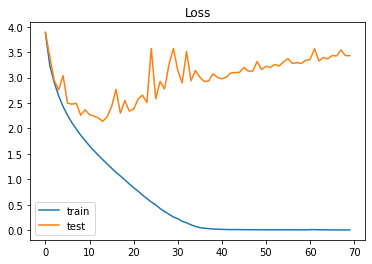

In [ ]:
plt.plot(output.history["loss"])
plt.plot(output.history["val_loss"])
plt.legend(['train','test'])
plt.title('Loss')


Text(0.5, 1.0, 'Accuracy')

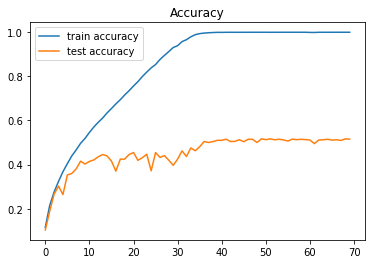

In [ ]:
plt.plot(output.history["accuracy"])
plt.plot(output.history["val_accuracy"])
plt.legend(['train accuracy','test accuracy'])
plt.title('Accuracy')

(100.0, 0.0)

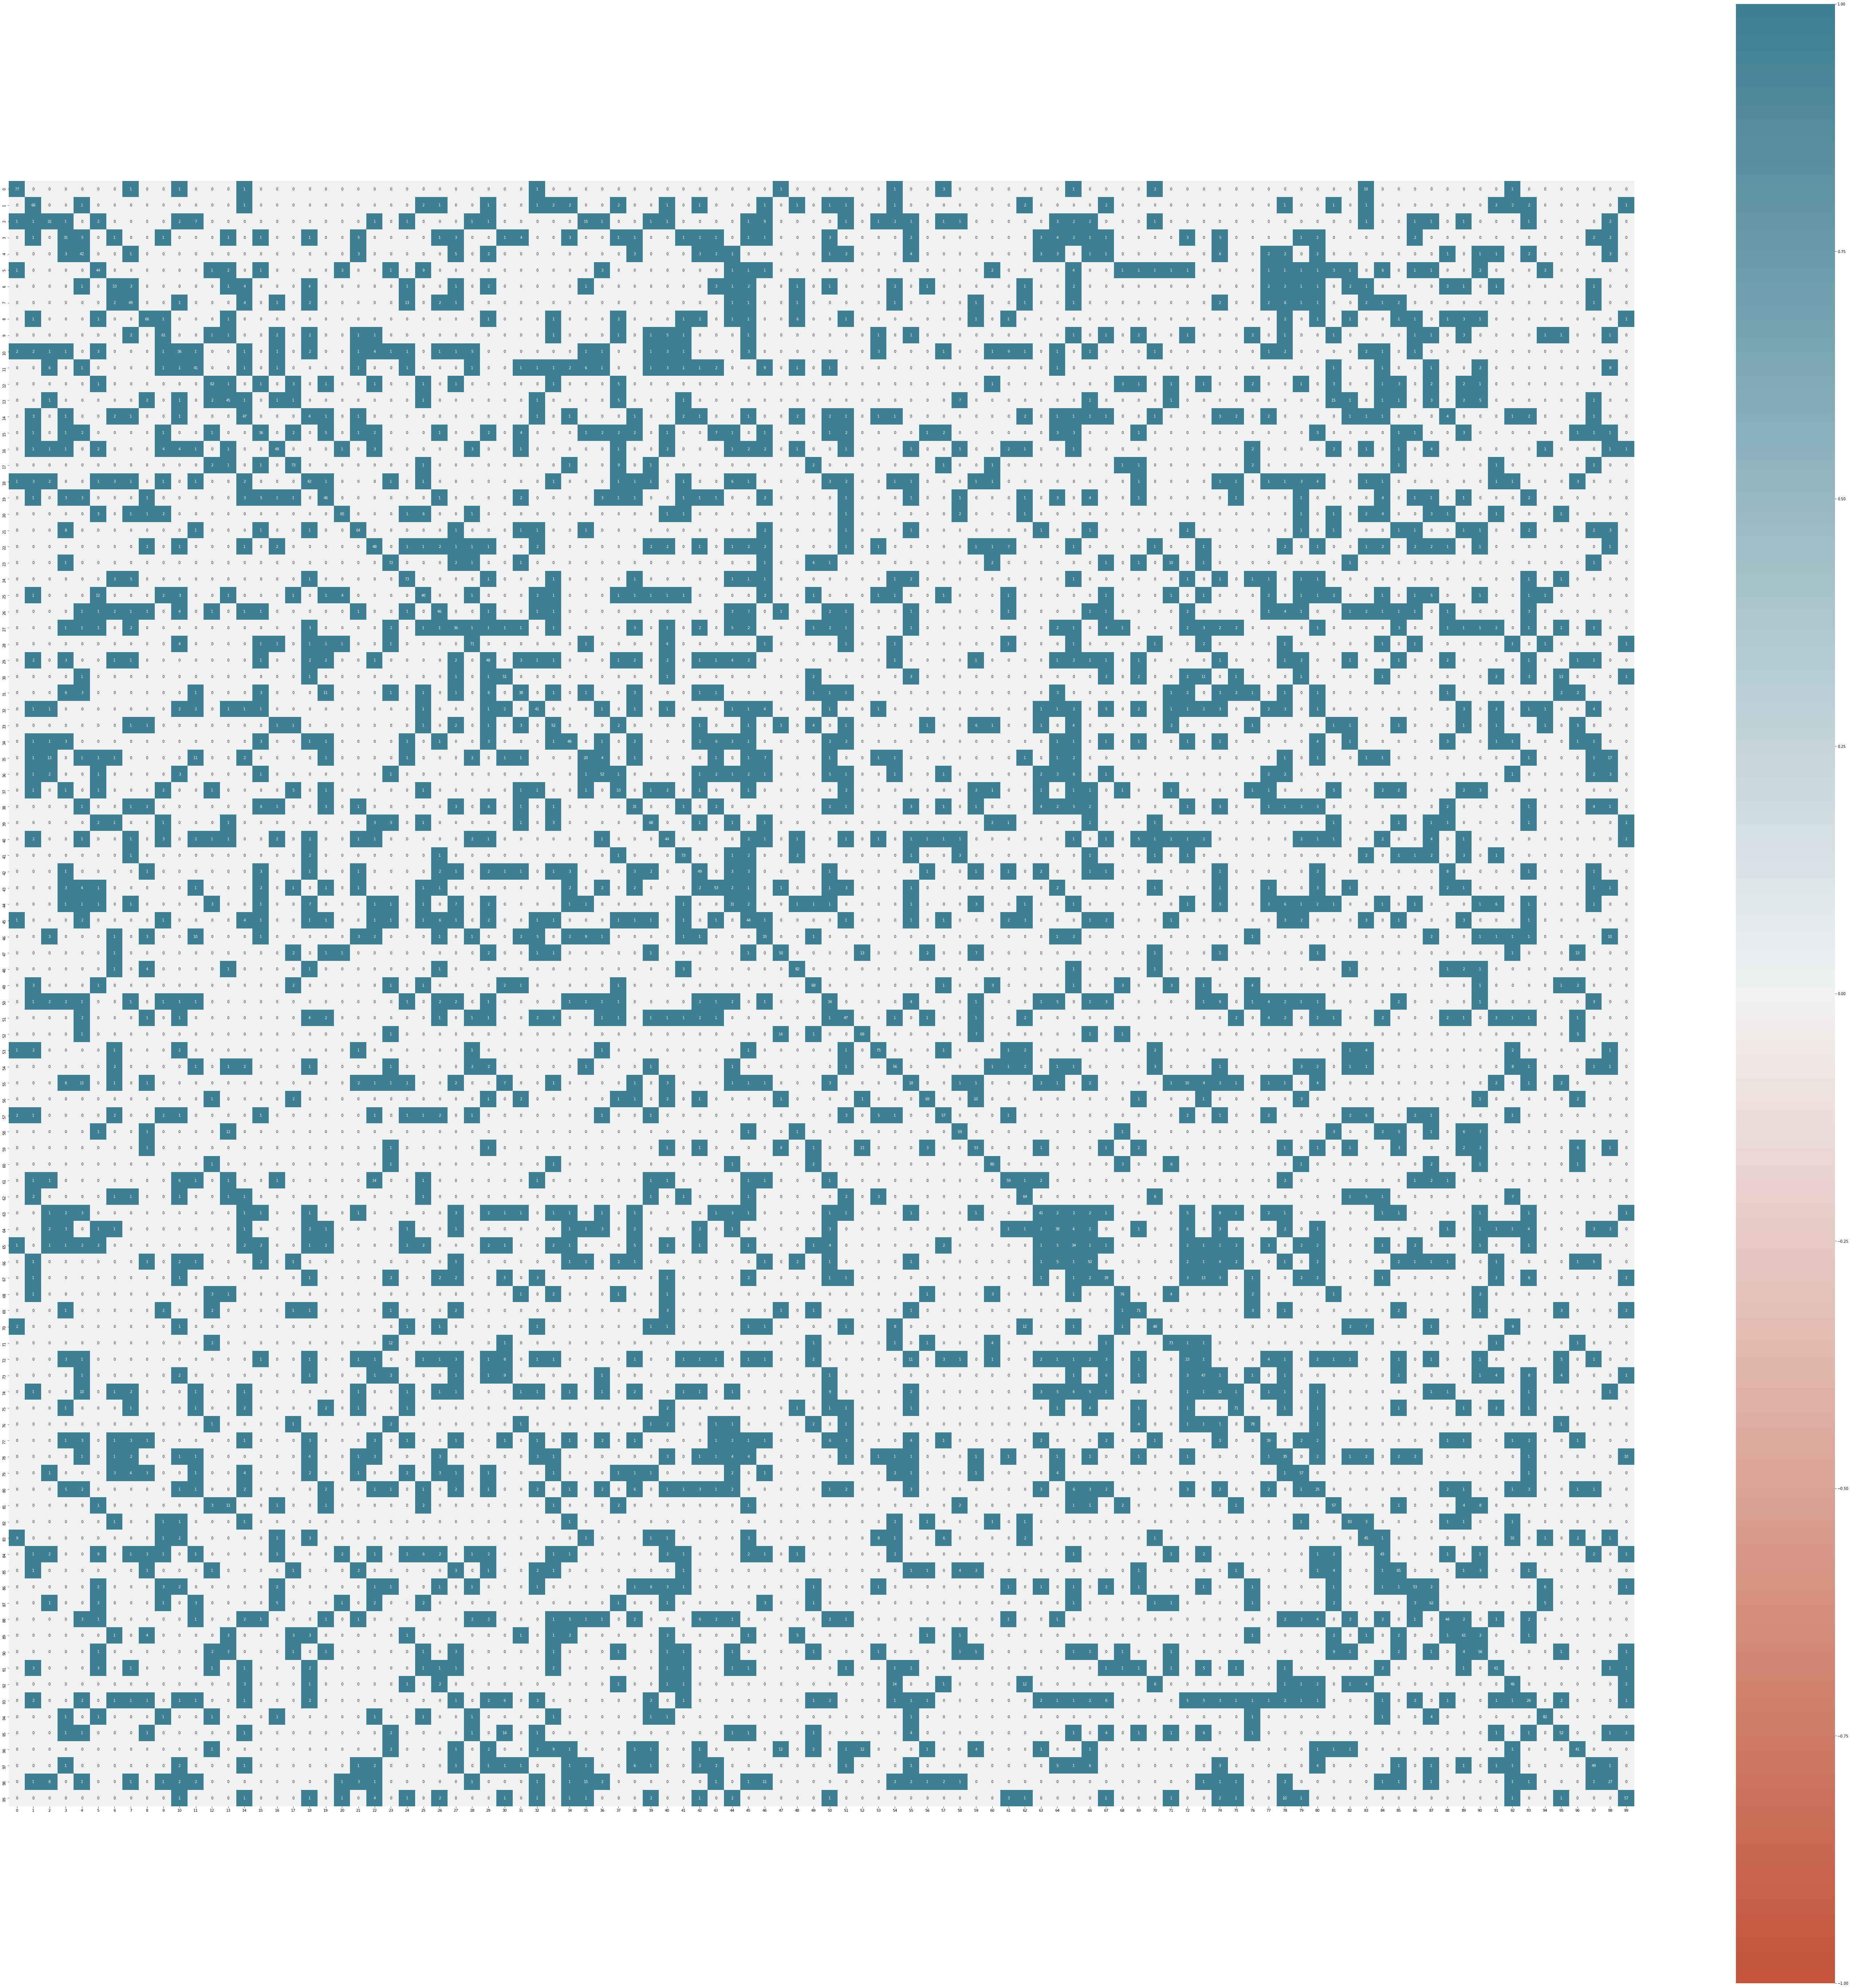

In [16]:
import seaborn as sns 

plt.figure(figsize = (100,100))  #This is the size of the image
heatM = sns.heatmap(confusion_matrix(y_true, y_pred), vmin = -1, vmax = 1,center = 0, cmap = sns.diverging_palette(20, 220, n = 200),  square = True, annot = True) #this are the caracteristics of the heatmap
heatM.set_ylim([100,0]) # This is the limit in y axis (number of features)
